In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
import keras_tuner as kt
from keras.layers import LSTM, Dense, Dropout
from keras import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import datetime as dt

## Step 1

## 1. a

Let us download the data for the Titan stock

In [81]:
stock_data = yf.Ticker("TITAN.NS").history(start="2017-01-01", end="2024-12-31")

In [83]:
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-02 00:00:00+05:30,315.502586,322.552096,312.193610,320.298187,656084,0.0,0.0
2017-01-03 00:00:00+05:30,327.060050,340.104093,325.285672,333.917755,2773103,0.0,0.0
2017-01-04 00:00:00+05:30,336.075739,347.153596,334.924812,344.947601,2371009,0.0,0.0
2017-01-05 00:00:00+05:30,345.762851,346.721971,340.919305,343.412994,1187872,0.0,0.0
2017-01-06 00:00:00+05:30,344.324149,348.160630,338.185786,340.679504,1089982,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-23 00:00:00+05:30,3378.100098,3406.300049,3336.649902,3396.949951,691202,0.0,0.0
2024-12-24 00:00:00+05:30,3385.350098,3419.000000,3338.199951,3353.399902,485245,0.0,0.0
2024-12-26 00:00:00+05:30,3365.000000,3371.850098,3312.649902,3323.050049,637094,0.0,0.0


In [85]:
stock_data.head() #first look at the data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-02 00:00:00+05:30,315.502586,322.552096,312.193610,320.298187,656084,0.0,0.0
2017-01-03 00:00:00+05:30,327.060050,340.104093,325.285672,333.917755,2773103,0.0,0.0
2017-01-04 00:00:00+05:30,336.075739,347.153596,334.924812,344.947601,2371009,0.0,0.0
2017-01-05 00:00:00+05:30,345.762851,346.721971,340.919305,343.412994,1187872,0.0,0.0
2017-01-06 00:00:00+05:30,344.324149,348.160630,338.185786,340.679504,1089982,0.0,0.0


Let us consider the closing prices for the analysis and model building to follow.

In [88]:
stock_prices = stock_data["Close"]

Let us perform some exploratory analysis on the closing prices.

In [91]:
stock_prices.describe() #summary statistics

count    1974.000000
mean     1777.024130
std      1020.301013
min       320.298187
25%       905.107513
50%      1420.720703
75%      2562.747559
max      3854.039062
Name: Close, dtype: float64

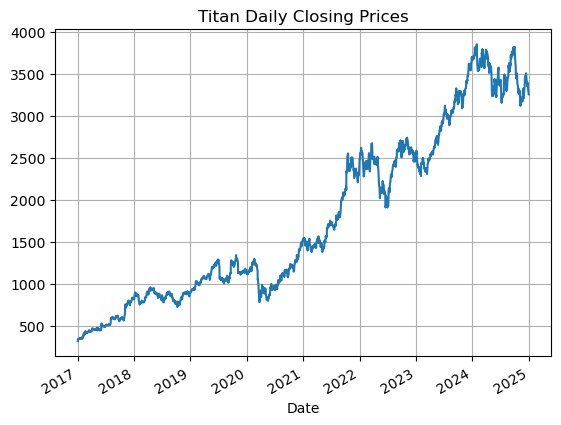

In [93]:
stock_prices.plot()
plt.title("Titan Daily Closing Prices")
plt.grid()

Despite some prices corrections, there appears to be a general rising trend in this stock over the years

Let us now look at the skew and kurtosis.

In [97]:
stock_prices.skew()

0.4788396459924155

In [99]:
stock_prices.kurtosis()

-1.1356475289698953

Let us now check for stationarity

In [102]:
adf_result = adfuller(stock_prices)
adf_statistic = adf_result[0] 
p_value = adf_result[1]
used_lags = adf_result[2] 
critical_values = adf_result[4] 

adf_statistic, p_value, used_lags, critical_values

(-0.6927549164710374,
 0.8486172629177092,
 4,
 {'1%': -3.433675467561267,
  '5%': -2.863008999826203,
  '10%': -2.5675520348463654})

The series is not stationary, as the p-value is greater than 0.05. The ADF statistic is also higher than all critical values.

Let us check for the presence of persistence in the series

In [106]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(stock_prices.autocorr(lag = i))

0.9995098501235516
0.9974090942183587
0.994880270373017
0.9763846324044606
0.9581783377427333
0.9292831670282055
0.9138901418023251
0.8339297669499727


Clearly, high autocorrelation is present in the stock.

Text(0.5, 1.0, 'Histogram of Titan Closing Prices')

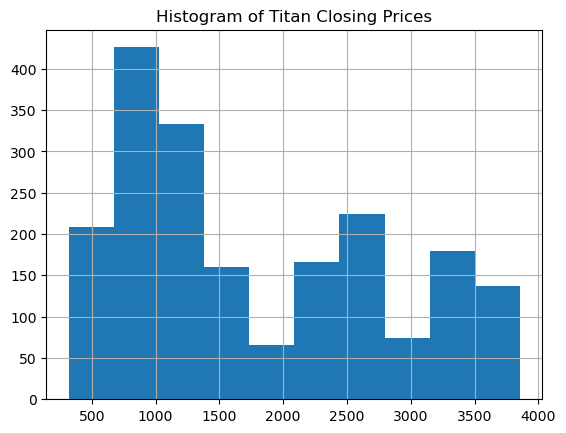

In [109]:
stock_prices.hist()
plt.title("Histogram of Titan Closing Prices")

Let us try to build predictive models on this dataset to predict future prices

Suppose we consider that data before 2023 should be used for training, and data 2023 onwards for testing, we get a 75:25 train-test split. We would have 1484 data points in the train set, and 490 in the test set.

In [73]:
train = stock_prices[stock_prices.index<"2023-01-01"]
test = stock_prices[stock_prices.index>"2023-01-01"]

In [133]:
len(train)/(len(train)+len(test))

0.75177304964539

In [135]:
len(train)

1484

In [137]:
len(test)

490

## 1. b and 1. c

Now, let us build models to forecast future prices of this stock. Here, there will be some leakage of data between the train and test data sets. I ensure data leakage in the following ways:
1. I scale the entire data before splitting it into train and test sets.
2. I use random shuffling in when performing cross-validation during training.

In [124]:
scaler = MinMaxScaler()
stock_prices_scaled = scaler.fit_transform(stock_prices.to_frame())

In [126]:
stock_prices_scaled

array([[0.        ],
       [0.00385415],
       [0.00697544],
       ...,
       [0.84973742],
       [0.84581804],
       [0.83114524]])

Now, the train-test split happens. Here, I use the train-test ratio described just a few cells above to achieve a 75:25 chronological split.

In [187]:
train_scaled = stock_prices_scaled[:1484]
test_scaled = stock_prices_scaled[1484:]

In [189]:
len(train_scaled)

1484

In [191]:
len(test_scaled)

490

First, I build an MLP model.

In [194]:
train_scaled = pd.DataFrame(train_scaled)
train_scaled.columns = ['Close']
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = ['Close']

In [196]:
train_scaled

,Close
0,0.000000
1,0.003854
2,0.006975
3,0.006541
4,0.005768
...,...
1479,0.604554
1480,0.610844
1481,0.632307
1482,0.624770


<Axes: >

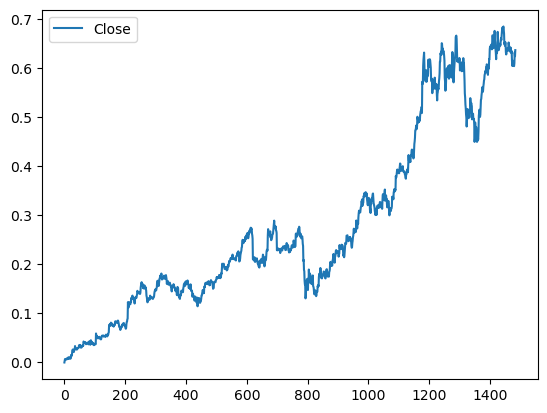

In [198]:
train_scaled.plot()

Let us build the features as well as the target for the model. Let the target be the price for the next day. Since the time series has autocorrelation and persistence, I will try to use values from the immediate past few days to predict the prices on the next day. Information from previous days will be incorporated using moving averages.

In [201]:
train_scaled["1d_lag"] = train_scaled["Close"].shift(1)
train_scaled["2d_mva"] = train_scaled["Close"].rolling(2).mean()
train_scaled["5d_mva"] = train_scaled["Close"].rolling(5).mean()
train_scaled["7d_mva"] = train_scaled["Close"].rolling(7).mean()
train_scaled["10d_mva"] = train_scaled["Close"].rolling(10).mean()
train_scaled["20d_mva"] = train_scaled["Close"].rolling(10).mean()
train_scaled["Target"] = train_scaled["Close"].shift(-1)
train_scaled

,Close,1d_lag,2d_mva,5d_mva,7d_mva,10d_mva,20d_mva,Target
0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.003854
1,0.003854,0.000000,0.001927,NaN,NaN,NaN,NaN,0.006975
2,0.006975,0.003854,0.005415,NaN,NaN,NaN,NaN,0.006541
3,0.006541,0.006975,0.006758,NaN,NaN,NaN,NaN,0.005768
4,0.005768,0.006541,0.006154,0.004628,NaN,NaN,NaN,0.005605
...,...,...,...,...,...,...,...,...
1479,0.604554,0.605100,0.604827,0.606762,0.607830,0.613751,0.613751,0.610844
1480,0.610844,0.604554,0.607699,0.606504,0.608659,0.611724,0.611724,0.632307
1481,0.632307,0.610844,0.621576,0.611578,0.610994,0.611417,0.611417,0.624770
1482,0.624770,0.632307,0.628539,0.615515,0.612800,0.612273,0.612273,0.637169


Now, let us drop all null values

In [204]:
train_scaled.dropna(inplace=True)

In [206]:
train_scaled

,Close,1d_lag,2d_mva,5d_mva,7d_mva,10d_mva,20d_mva,Target
9,0.006623,0.008075,0.007349,0.007008,0.006764,0.005818,0.005818,0.007844
10,0.007844,0.006623,0.007233,0.007456,0.006950,0.006602,0.006602,0.007057
11,0.007057,0.007844,0.007450,0.007374,0.007134,0.006923,0.006923,0.008970
12,0.008970,0.007057,0.008014,0.007714,0.007615,0.007122,0.007122,0.010517
13,0.010517,0.008970,0.009744,0.008202,0.008051,0.007520,0.007520,0.007260
...,...,...,...,...,...,...,...,...
1478,0.605100,0.605086,0.605093,0.609043,0.609495,0.616653,0.616653,0.604554
1479,0.604554,0.605100,0.604827,0.606762,0.607830,0.613751,0.613751,0.610844
1480,0.610844,0.604554,0.607699,0.606504,0.608659,0.611724,0.611724,0.632307
1481,0.632307,0.610844,0.621576,0.611578,0.610994,0.611417,0.611417,0.624770


Now, to build the MLP

In [209]:
tf.keras.backend.clear_session()  # We clear the backend to reset the random seed process
tf.random.set_seed(42)

act_fun = "relu"
hp_units_1 = 10
hp_units_2 = 12
hp_units_3 = 6
hp_units_4 = 4
#n_dropout = 0.2

In [255]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun, input_shape=(7,)))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
#model.add(tf.keras.layers.Dropout(n_dropout)
model.add(tf.keras.layers.Dense(units=hp_units_4, activation=act_fun))
model.add(tf.keras.layers.Dense(units=1)) #activation function

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [265]:
hp_lr = 1e-4  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="mse", metrics=["mae"])

In [267]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=20,
    restore_best_weights=True,
)

In [269]:
X_train_scaled = train_scaled[['Close', '1d_lag', '2d_mva', '5d_mva', '7d_mva', '10d_mva', '20d_mva']]
y_train_scaled = train_scaled[['Target']]	

In [271]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=2,
    callbacks = [es],
)

Epoch 1/100
37/37 - 3s - 74ms/step - loss: 1.3940e-04 - mae: 0.0080 - val_loss: 9.2752e-04 - val_mae: 0.0269
Epoch 2/100
37/37 - 0s - 7ms/step - loss: 1.1315e-04 - mae: 0.0072 - val_loss: 6.0262e-04 - val_mae: 0.0210
Epoch 3/100
37/37 - 0s - 7ms/step - loss: 1.0531e-04 - mae: 0.0071 - val_loss: 4.8925e-04 - val_mae: 0.0186
Epoch 4/100
37/37 - 0s - 6ms/step - loss: 1.0133e-04 - mae: 0.0070 - val_loss: 4.3831e-04 - val_mae: 0.0174
Epoch 5/100
37/37 - 0s - 6ms/step - loss: 9.8242e-05 - mae: 0.0068 - val_loss: 4.0715e-04 - val_mae: 0.0166
Epoch 6/100
37/37 - 0s - 7ms/step - loss: 9.5434e-05 - mae: 0.0067 - val_loss: 3.8769e-04 - val_mae: 0.0161
Epoch 7/100
37/37 - 0s - 6ms/step - loss: 9.3196e-05 - mae: 0.0066 - val_loss: 3.7704e-04 - val_mae: 0.0158
Epoch 8/100
37/37 - 0s - 6ms/step - loss: 9.1304e-05 - mae: 0.0065 - val_loss: 3.4757e-04 - val_mae: 0.0150
Epoch 9/100
37/37 - 0s - 7ms/step - loss: 8.9913e-05 - mae: 0.0065 - val_loss: 3.3170e-04 - val_mae: 0.0145
Epoch 10/100
37/37 - 0s - 8

In [275]:
train_pred = model.predict(X_train_scaled)
r2_score(y_train_scaled, train_pred)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.9966583251953125

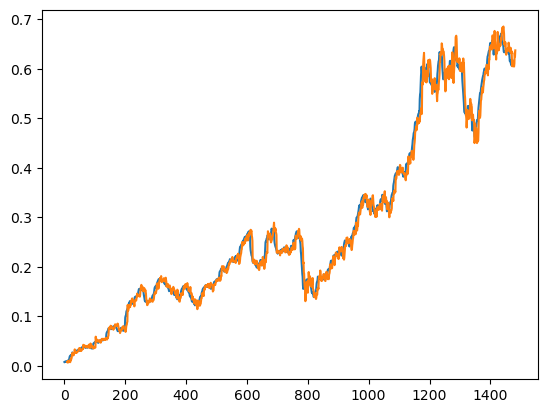

In [283]:
plt.plot(train_pred)
plt.plot(y_train_scaled)

Now, we build the LSTM Model